In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import cluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import spacy # if this gives an error, downgrade to python 3.12.3
nlp = spacy.load("en_core_web_lg")

from tqdm import tqdm
tqdm.pandas()

In [2]:
# Extract word vectors from a list of noun chunks
# Returns a dictionary mapping words to their index in the matrix, and the matrix itself
def extract_vectors(noun_chunks):
    word_vectors = {}
    # set as upper bounds (assuming no duplicates)
    word_vector_matrix = np.zeros(shape=(len(noun_chunks), 300))

    #TODO: rewrite to be pythonic
    i = 0
    for word in noun_chunks:
        if word.text in word_vectors:
            continue
        word_vector_matrix[i,:] = word.vector
        word_vectors[word.text] = i
        i = i + 1

    word_vector_matrix = word_vector_matrix[:i,:]
    
    return word_vectors, word_vector_matrix


# Load sample words
sample_words = pandas.read_json("example_words.json")
sample_words = [nlp(x).noun_chunks for x in sample_words]
sample_words = [x for xs in sample_words for x in xs]

# Extract word vectors from words
wv_mapping, wv_matrix = extract_vectors(sample_words)
reverse_wv_mapping = {v: k for k, v in wv_mapping.items()}

NameError: name 'pandas' is not defined

In [ ]:
# Attempt agglomerative clustering
model = AgglomerativeClustering(n_clusters = None, distance_threshold = 60, linkage = 'ward')
y = model.fit_predict(wv_matrix)

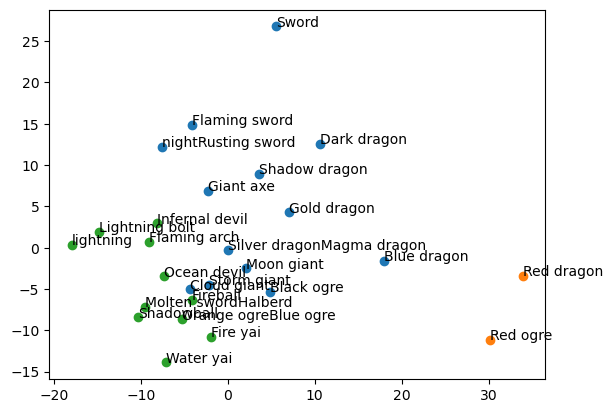

Number of clusters:  3
Number of words:  26
Average words per cluster: 8.666666666666666


In [ ]:
# visualization
rows, shapes = wv_matrix.shape

# use PCA (not for clustering, just dim reduction)
pca = PCA(n_components=2)
reduced_wv_matrix = pca.fit_transform(wv_matrix)

disp = np.random.choice(np.arange(0,reduced_wv_matrix.shape[0]), size=rows, replace = False)
disp_values = reduced_wv_matrix[disp]
disp_clusters = y[disp]
disp_names = np.array([name for name in reverse_wv_mapping.values()])[disp]

# plot
fig, ax = plt.subplots()
for unique_y in np.unique(disp_clusters):
    disp_x = disp_values[disp_clusters == unique_y,0]
    disp_y = disp_values[disp_clusters == unique_y,1]
    ax.scatter(disp_x, disp_y)
    for i, txt in enumerate(disp_names[disp_clusters == unique_y]):
        ax.annotate(txt, (disp_x[i], disp_y[i]))

plt.show()

unique, counts = np.unique(y, return_counts=True)
print(f'Number of clusters: {len(unique)}'
print(f'Number of words: {len(sample_words)}')
print('Average words per cluster: ', np.mean(counts))

Issues:

- It seems to work, but there should be multiple types of clusters for different parts of things

![alt text](res/afc1891f-d610-406e-85d1-bc5b552868cd.png)


- For example: *blue dragon*- should this go into 'blue' or 'dragon'?
- Similarly, for stuff like *giant sword*- this is even more ambiguous. Should it go into giant, or sword? Should giant be a noun or an adjective (it can be both here, as 'sword belonging to the giants' or 'sword that is physically large')

In [ ]:
# TODO:
# - check other columns of items/spells (ie 'onset' for damage type, 'trigger', etc)
# - creature. maybe should include: immunity? resistance? weakness? skill? alignment?
# - spell. target? (seems to be able to be 'one undead' etc)
# - creature's spells? should these be included?
# -